In [1]:
import kaggle

kaggle.api.authenticate()

kaggle.api.dataset_download_files('cashutosh/gender-classification-dataset', path='D:/downloads', unzip=True)

Dataset URL: https://www.kaggle.com/datasets/cashutosh/gender-classification-dataset


In [2]:
import torch
from torchvision import datasets, transforms
from torch.utils.data import DataLoader

# Paths to your train and val folders
train_dir = 'D:\downloads/faces-dataset/Training'
val_dir = 'D:\downloads/faces-dataset/Validation'



transform = transforms.Compose([
        transforms.Resize((64,64)),
        transforms.ToTensor(),
        transforms.Normalize(mean=(0.5, 0.5, 0.5), std=(0.5, 0.5, 0.5))
])

# Load the training and validation datasets
train_dataset = datasets.ImageFolder(root=train_dir, transform=transform)
val_dataset = datasets.ImageFolder(root=val_dir, transform=transform)


# Define batch size
batch_size = 32

# Create DataLoaders for train and validation datasets
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)


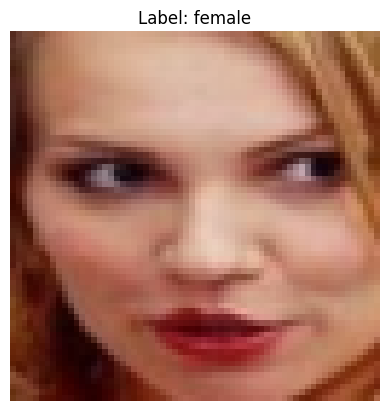

In [10]:
import matplotlib.pyplot as plt
import numpy as np
# Function to denormalize the image for display
def denormalize(image):
    mean = np.array([0.5, 0.5, 0.5])
    std = np.array([0.5, 0.5, 0.5])
    image = image.numpy().transpose((1, 2, 0))  # Convert tensor to NumPy array
    image = std * image + mean  # De-normalize
    image = np.clip(image, 0, 1)  # Clip pixel values to the range [0, 1]
    return image

# Get the class names from the dataset
class_names = train_dataset.classes

# Function to display an image and its label
def show_image(img, label):
    img = denormalize(img)  # De-normalize the image
    plt.imshow(img)  # Display the image
    plt.title(f'Label: {class_names[label]}')  # Show the class name as title
    plt.axis('off')  # Hide the axis
    plt.show()

# Display a single image and its label from the train_loader
for images, labels in train_loader:
    image = images[0]  # Extract the first image in the batch
    label = labels[0].item()  # Extract the label
    show_image(image, label)  # Display the image and label
    break  # Display only the first image

In [5]:
import torch
print(torch.cuda.is_available())
print(torch.cuda.current_device())

True
0


In [4]:
import os
os.environ['CUDA_LAUNCH_BLOCKING'] = '1'
os.environ['TORCH_USE_CUDA_DSA'] = '1'



In [5]:
torch.cuda.empty_cache()


In [6]:
class_names

['female', 'male']

In [1]:
import torch
import torch.nn as nn

class Discriminator(nn.Module):
    def __init__(self, num_classes, img_size, channels):
        super().__init__()

        self.label_emb = nn.Embedding(num_classes, 1)  # Embedding for num_classes labels (1D embedding)

        self.conv_blocks = nn.Sequential(
            nn.Conv2d(channels + 1, 64, 4, stride=2, padding=1),  # Input channels: image channels + 1 (label embedding)
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(64, 128, 4, stride=2, padding=1),
            nn.BatchNorm2d(128),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(128, 256, 4, stride=2, padding=1),
            nn.BatchNorm2d(256),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(256, 512, 4, stride=2, padding=1),
            nn.BatchNorm2d(512),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(512, 1, 4, padding=0),  # Output a single value (validity score)
            nn.Sigmoid()
        )

    def forward(self, img, labels):
        # Expand the label embedding to match the spatial dimensions of the input image (img_size x img_size)
        label_embedding = self.label_emb(labels).unsqueeze(2).unsqueeze(3)
        label_embedding = label_embedding.expand(label_embedding.size(0), 1, img.size(2), img.size(3))
        
        # Concatenate the image and the label embedding along the channel axis
        d_in = torch.cat((img, label_embedding), 1)  # Concatenate along channel axis (image channels + 1 for label)
        validity = self.conv_blocks(d_in)
        return validity.view(-1, 1).squeeze(1)  # Output a scalar (validity score)

# Instantiate the discriminator
# Instantiate the generator
latent_dim = 100  # Size of the latent space (z)
num_classes = 2  # You can change this to any number of classes
img_size = 64  # Size of the image (64x64)
channels = 3  # Number of image channels (e.g., 3 for RGB, 1 for grayscale)
discriminator = Discriminator(num_classes, img_size, channels).cuda()
print(discriminator)

Discriminator(
  (label_emb): Embedding(2, 1)
  (conv_blocks): Sequential(
    (0): Conv2d(4, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (1): LeakyReLU(negative_slope=0.2, inplace=True)
    (2): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (3): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (4): LeakyReLU(negative_slope=0.2, inplace=True)
    (5): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (6): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (7): LeakyReLU(negative_slope=0.2, inplace=True)
    (8): Conv2d(256, 512, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (9): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): LeakyReLU(negative_slope=0.2, inplace=True)
    (11): Conv2d(512, 1, kernel_size=(4, 4), stride=(1, 1))
    (12): Sigmoid()
  )
)


In [2]:
class Generator(nn.Module):
    def __init__(self, latent_dim, num_classes, img_size, channels):
        super().__init__()
        
        self.label_emb = nn.Embedding(num_classes, num_classes)  # Embedding for num_classes labels

        self.init_size = img_size // 4  # Initial size after the first upsampling
        self.l1 = nn.Sequential(nn.Linear(latent_dim + num_classes, 128 * self.init_size * self.init_size))

        self.conv_blocks = nn.Sequential(
            nn.BatchNorm2d(128),
            nn.ConvTranspose2d(128, 128, 4, stride=2, padding=1),
            nn.BatchNorm2d(128, 0.8),
            nn.LeakyReLU(0.2, inplace=True),
            nn.ConvTranspose2d(128, 64, 4, stride=2, padding=1),
            nn.BatchNorm2d(64, 0.8),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(64, channels, 3, stride=1, padding=1),
            nn.Tanh()
        )

    def forward(self, z, labels):
        label_embedding = self.label_emb(labels)
        gen_input = torch.cat((z, label_embedding), -1)
        out = self.l1(gen_input)
        out = out.view(out.size(0), 128, self.init_size, self.init_size)
        img = self.conv_blocks(out)
        return img  # Output is (batch_size, channels, img_size, img_size) RGB or grayscale image


generator = Generator(latent_dim, num_classes, img_size, channels).cuda()
print(generator)

Generator(
  (label_emb): Embedding(2, 2)
  (l1): Sequential(
    (0): Linear(in_features=102, out_features=32768, bias=True)
  )
  (conv_blocks): Sequential(
    (0): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (1): ConvTranspose2d(128, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (2): BatchNorm2d(128, eps=0.8, momentum=0.1, affine=True, track_running_stats=True)
    (3): LeakyReLU(negative_slope=0.2, inplace=True)
    (4): ConvTranspose2d(128, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (5): BatchNorm2d(64, eps=0.8, momentum=0.1, affine=True, track_running_stats=True)
    (6): LeakyReLU(negative_slope=0.2, inplace=True)
    (7): Conv2d(64, 3, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): Tanh()
  )
)


In [4]:
criterion = nn.BCELoss()
d_optimizer = torch.optim.Adam(discriminator.parameters(), lr=1e-4)
g_optimizer = torch.optim.Adam(generator.parameters(), lr=1e-4)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')


In [11]:
import torch
import torch.nn as nn
from torch.autograd import Variable

def generator_train_step(batch_size, discriminator, generator, g_optimizer, criterion):
    g_optimizer.zero_grad()
    z = Variable(torch.randn(batch_size, 100)).to(device)
    fake_labels = Variable(torch.LongTensor(np.random.randint(0, num_classes, batch_size))).to(device)
    fake_images = generator(z, fake_labels)
    validity = discriminator(fake_images, fake_labels)
    g_loss = criterion(validity, Variable(torch.ones(batch_size)).to(device))
    g_loss.backward()
    g_optimizer.step()
    return g_loss.data

def discriminator_train_step(batch_size, discriminator, generator, d_optimizer, criterion, real_images, labels):
    d_optimizer.zero_grad()

    # Ensure real images and labels are on the same device
    real_images = real_images.to(device)
    labels = labels.to(device)

    # Train with real images
    real_validity = discriminator(real_images, labels)
    real_loss = criterion(real_validity, Variable(torch.ones(batch_size)).to(device))

    # Train with fake images
    z = Variable(torch.randn(batch_size, 100)).to(device)
    fake_labels = Variable(torch.LongTensor(np.random.randint(0, num_classes, batch_size))).to(device)
    fake_images = generator(z, fake_labels)
    fake_validity = discriminator(fake_images, fake_labels)
    fake_loss = criterion(fake_validity, Variable(torch.zeros(batch_size)).to(device))

    d_loss = real_loss + fake_loss
    d_loss.backward()
    d_optimizer.step()
    return d_loss.data
device

device(type='cuda')

In [5]:
# Load the saved model and optimizer states if they exist
checkpoint = torch.load("cgan_model_face.pth")

# Initialize generator and discriminator
generator = Generator(latent_dim, num_classes, img_size, channels).to(device)
discriminator = Discriminator(num_classes, img_size, channels).to(device)

# Initialize optimizers
g_optimizer = torch.optim.Adam(generator.parameters(), lr=0.0002, betas=(0.5, 0.999))
d_optimizer = torch.optim.Adam(discriminator.parameters(), lr=0.0002, betas=(0.5, 0.999))

# Load the model states
generator.load_state_dict(checkpoint['generator_state_dict'])
discriminator.load_state_dict(checkpoint['discriminator_state_dict'])

# Load the optimizer states if resuming training
g_optimizer.load_state_dict(checkpoint['g_optimizer_state_dict'])
d_optimizer.load_state_dict(checkpoint['d_optimizer_state_dict'])

# Load the epoch to resume training
start_epoch = checkpoint['epoch']

print(f"Resuming training from epoch {start_epoch}...")


Resuming training from epoch 149...


In [39]:
from tqdm import tqdm
import torch
from PIL import Image
from torch import autograd
from torch.autograd import Variable
from torchvision.utils import make_grid
import matplotlib.pyplot as plt
import numpy as np

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# General parameters
num_epochs = 150
n_critic = 5
display_step = 300
latent_dim = 100  # Dimension of the latent vector z
num_classes = 2  # Number of classes (generalized for any dataset)
channels = 3  # Number of channels (3 for RGB, 1 for grayscale)
image_size = 64  # Image size (64x64)
num_samples = 5  # Number of images to generate in each epoch

for epoch in range(start_epoch, num_epochs):
    print('Starting epoch {}...'.format(epoch))
    
    # Add tqdm progress bar for each batch within an epoch
    progress_bar = tqdm(enumerate(train_loader), total=len(train_loader))
    
    for i, (images, labels) in progress_bar:
        real_images = Variable(images).to(device)
        labels = Variable(labels).to(device)
        generator.train()
        batch_size = real_images.size(0)
        
        # Training discriminator
        d_loss = discriminator_train_step(len(real_images), discriminator,
                                          generator, d_optimizer, criterion,
                                          real_images, labels)

        # Training generator
        g_loss = generator_train_step(batch_size, discriminator, generator, g_optimizer, criterion)
        
        # Update progress bar description with current loss values
        progress_bar.set_description(f"[Epoch {epoch+1}/{num_epochs}] g_loss: {g_loss:.4f}, d_loss: {d_loss:.4f}")

    generator.eval()
    print('g_loss: {}, d_loss: {}'.format(g_loss, d_loss))
    # Saving the generator and discriminator models
    torch.save({
        'generator_state_dict': generator.state_dict(),
        'discriminator_state_dict': discriminator.state_dict(),
        'g_optimizer_state_dict': g_optimizer.state_dict(),
        'd_optimizer_state_dict': d_optimizer.state_dict(),
        'epoch': epoch  # Save the current epoch if you want to resume training
    }, 'cgan_model_face.pth')
    
    print("Model saved successfully.")
    # Generate new sample images
    z = Variable(torch.randn(1, latent_dim)).to(device)  # Generalized latent vector size
    labels = Variable(torch.LongTensor(np.arange(1))).to(device)  # Generate labels for the images

    # Generate images using the generator
    sample_images = generator(z, labels).data.cpu()

    # Display the generated images in a grid
    grid = make_grid(sample_images, nrow=num_samples, normalize=True).permute(1, 2, 0).numpy()

    # Display the grid of images using matplotlib
    plt.imshow(grid)
    plt.show()


Starting epoch 73...


[Epoch 74/150] g_loss: 4.8165, d_loss: 0.0958:   1%|▍                                | 19/1470 [00:06<08:07,  2.98it/s]


KeyboardInterrupt: 

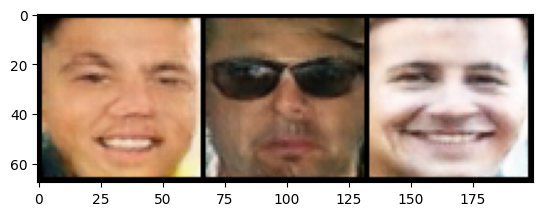

In [58]:
from torchvision.utils import make_grid
import matplotlib.pyplot as plt

# Set generator to evaluation mode
generator.eval()

# Generate new sample images
num_samples = 3
z = torch.randn(num_samples, 100).to(device)

# Manually specify labels (1 for man, 0 for woman)
labels = torch.tensor([1,1,1]).to(device)  # Example: alternating labels

# Generate images
with torch.no_grad():
    sample_images = generator(z, labels).data.cpu()

# Visualize the generated images with labels
grid = make_grid(sample_images, nrow=5, normalize=True).permute(1, 2, 0).numpy()
plt.imshow(grid)
# plt.title(f'Labels: {labels.cpu().numpy()}')
plt.show()
